#  Load Karate Club

In [1]:
from networkx import to_numpy_matrix, degree_centrality, betweenness_centrality, shortest_path_length
from src.data.datasets import load_karate_club
import mxnet.ndarray as nd

zkc = load_karate_club()

A = to_numpy_matrix(zkc.meta_data['graph'])
A = nd.array(A)

X_train = zkc.X_train.flatten()
y_train = zkc.y_train
X_test = zkc.X_test.flatten()
y_test = zkc.y_test

# Spectral Rule Implementation

In [2]:
from mxnet.gluon import HybridBlock
from mxnet.gluon.nn import Activation
import mxnet.ndarray as nd

class SpectralRule(HybridBlock):
    def __init__(self, A, in_units, out_units, activation='relu', **kwargs):
        super().__init__(**kwargs)
        I = nd.eye(*A.shape)
        A_hat = A.copy() + I

        D = nd.sum(A_hat, axis=0)
        D_inv = D**-0.5
        D_inv = nd.diag(D_inv)

        A_hat = D_inv * A_hat * D_inv
        
        self.in_units, self.out_units = in_units, out_units
        
        with self.name_scope():
            self.A_hat = self.params.get_constant('A_hat', A_hat)
            self.W = self.params.get(
                'W', shape=(self.in_units, self.out_units)
            )
            if activation == 'identity':
                self.activation = lambda X: X
            else:
                self.activation = Activation(activation)

    def hybrid_forward(self, F, X, A_hat, W):
        aggregate = F.dot(A_hat, X)
        propagate = self.activation(
            F.dot(aggregate, W))
        return propagate
    
    
class LogisticRegressor(HybridBlock):
    def __init__(self, in_units, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.w = self.params.get(
                'w', shape=(1, in_units)
            )
            """
            self.w = self.params.get_constant(
                'w', nd.array([[1, 1]])
            )
            """
            self.b = self.params.get(
                'b', shape=(1, 1)
            )
            """
            self.b = self.params.get_constant(
                'b', nd.array([[1]])
            )
            """
    def hybrid_forward(self, F, X, w, b):
        # Change shape of b to comply with MXnet addition API
        b = F.broadcast_axis(b, axis=(0,1), size=(34, 1))
        y = F.dot(X, w, transpose_b=True) + b

        return F.sigmoid(y)

# Models

In [3]:
from mxnet.gluon.nn import HybridSequential, Activation
from mxnet.ndarray import array
from mxnet.initializer import One, Uniform, Xavier
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

def build_features(A, X):
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')]
    in_units = in_units=X.shape[1]
  
    features = HybridSequential()
    with features.name_scope():
        for i, (layer_size, activation_func) in enumerate(
            hidden_layer_specs):
            layer = SpectralRule(A, in_units=in_units, out_units=layer_size, activation=activation_func)
            features.add(layer)

            in_units = layer_size
    return features, in_units

def build_model(A, X):
    model = HybridSequential()
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')]
    in_units = in_units=X.shape[1]

    with model.name_scope():
        features, out_units = build_features(A, X)
        model.add(features)

        classifier = LogisticRegressor(out_units)
        model.add(classifier)

    model.hybridize()
    model.initialize(Uniform(1))

    return model, features

## Model 1: Identity Matrix as Features

In [4]:
X_1 = I = nd.eye(*A.shape)
model_1, features_1 = build_model(A, X_1)
feature_representations_1 = [features_1(X_1).asnumpy()]
model_1(X_1)


[[0.5106776 ]
 [0.5095115 ]
 [0.51096225]
 [0.51542187]
 [0.52302504]
 [0.512526  ]
 [0.511652  ]
 [0.50208426]
 [0.5050117 ]
 [0.51883554]
 [0.5406651 ]
 [0.49158806]
 [0.5110878 ]
 [0.4936631 ]
 [0.5026252 ]
 [0.48504698]
 [0.5104648 ]
 [0.51194   ]
 [0.5220448 ]
 [0.5095117 ]
 [0.50140274]
 [0.50985765]
 [0.5303379 ]
 [0.51043373]
 [0.50124794]
 [0.52045095]
 [0.50941336]
 [0.49507195]
 [0.5021959 ]
 [0.50682354]
 [0.5085804 ]
 [0.51637703]
 [0.5098626 ]
 [0.5153003 ]]
<NDArray 34x1 @cpu(0)>

## Model 2: Distance to Administrator and Instructor as Features

In [5]:
X_2 = nd.zeros((A.shape[0], 2))
node_distance_instructor = shortest_path_length(zkc.meta_data['graph'], target=33)
node_distance_administrator = shortest_path_length(zkc.meta_data['graph'], target=0)

for node in zkc.meta_data['graph'].nodes():
    X_2[node][0] = node_distance_administrator[node]
    X_2[node][1] = node_distance_instructor[node]

X_2 = nd.concat(X_1, X_2)
model_2, features_2 = build_model(A, X_2)
feature_representations_2 = [features_2(X_2).asnumpy()]

# Train and Test Models

In [6]:
%time
from mxnet import autograd
from mxnet.gluon import Trainer
from mxnet.ndarray import sum as ndsum
import numpy as np

def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})

    feature_representations = []

    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)

            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]

        feature_representations.append(features(X).asnumpy())
            
        if (e % (epochs//10)) == 0:
            print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
            print(cum_preds)
    return feature_representations

def predict(model, X, nodes):
    preds = model(X)[nodes].asnumpy().flatten()
    return np.where(preds >= 0.5, 1, 0)

def evaluate(model, X, X_train, y_train, X_test, y_test):
    y_pred = predict(model, X, X_test)
    print(classification_report(y_test, y_pred))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


## Model 1

In [7]:
from sklearn.metrics import classification_report

feature_representations_1 += train(model_1, features_1, X_1, X_train, y_train, epochs=5000)
y_pred_1 = predict(model_1, X_1, X_test)
print(classification_report(y_test, y_pred_1))

Epoch 500/5000 -- Loss:  0.0001
[0.9999902, 4.623494e-05]
Epoch 1000/5000 -- Loss:  0.0000
[1.0, 8.9683305e-10]
Epoch 1500/5000 -- Loss:  0.0000
[1.0, 1.7521857e-14]
Epoch 2000/5000 -- Loss:  0.0000
[1.0, 3.429584e-19]
Epoch 2500/5000 -- Loss:  0.0000
[1.0, 6.7126565e-24]
Epoch 3000/5000 -- Loss:  0.0000
[1.0, 1.313875e-28]
Epoch 3500/5000 -- Loss:  0.0000
[1.0, 2.5716606e-33]
Epoch 4000/5000 -- Loss:  0.0000
[1.0, 5.060105e-38]
Epoch 4500/5000 -- Loss:  0.0000
[1.0, 0.0]
Epoch 5000/5000 -- Loss:  0.0000
[1.0, 0.0]
              precision    recall  f1-score   support

       False       0.62      0.50      0.55        16
        True       0.58      0.69      0.63        16

   micro avg       0.59      0.59      0.59        32
   macro avg       0.60      0.59      0.59        32
weighted avg       0.60      0.59      0.59        32



## Model 2

In [8]:
feature_representations_2 += train(model_2, features_2, X_2, X_train, y_train, epochs=250)
y_pred_2 = predict(model_2, X_2, X_test)
print(classification_report(y_test, y_pred_2))

Epoch 25/250 -- Loss:  1.4502
[0.46630818, 0.49708325]
Epoch 50/250 -- Loss:  1.4058
[0.48751295, 0.49711376]
Epoch 75/250 -- Loss:  1.3709
[0.5132726, 0.5053706]
Epoch 100/250 -- Loss:  1.3566
[0.5332241, 0.5170041]
Epoch 125/250 -- Loss:  1.3161
[0.5386774, 0.5021284]
Epoch 150/250 -- Loss:  1.1604
[0.5339666, 0.41315264]
Epoch 175/250 -- Loss:  0.8730
[0.5482581, 0.2381125]
Epoch 200/250 -- Loss:  0.5649
[0.625712, 0.09159248]
Epoch 225/250 -- Loss:  0.3007
[0.76565826, 0.033075787]
Epoch 250/250 -- Loss:  0.1270
[0.8933893, 0.014171541]
              precision    recall  f1-score   support

       False       0.83      0.94      0.88        16
        True       0.93      0.81      0.87        16

   micro avg       0.88      0.88      0.88        32
   macro avg       0.88      0.88      0.87        32
weighted avg       0.88      0.88      0.87        32



# Visualization

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_feature_representations(feature_representations, epoch=None):
    if epoch is None:
        epoch = len(feature_representations) - 1
    s = 200

    embedding = feature_representations[epoch]
    # 100 iterations: Instructor in one corner
    # 1500 iterations: Administrator in other corner

    graph = zkc.meta_data['graph']

    # Plot instructor
    instructor = {
        node
        for node in graph.nodes()
        if graph.nodes[node]['community'] == 'Instructor'
    }

    x, y = zip(*[embedding[node] for node in instructor - {33}])
    p1 = plt.scatter(x, y, c='C1', s=s)

    #Plot administrator
    administrator = {
        node
        for node in graph.nodes()
        if graph.nodes[node]['community'] == 'Administrator'
    }

    x, y = zip(*[embedding[node] for node in administrator - set([0])])
    p2 = plt.scatter(x, y, c='C0', s=s)

    # Plot Administrator and Instructor Nodes
    p3 = plt.scatter(*embedding[0], c='C0', s=s*1.5)
    plt.annotate('A', xy=embedding[0], ha='center', va='center')

    p4 = plt.scatter(*embedding[33], c='C1', s=s*1.5)
    plt.annotate('I', xy=embedding[33], ha='center', va='center')
    plt.title(f'Epoch {epoch}')
    
    return (p1, p2, p3, p4)

In [10]:
from networkx import (
    spring_layout, draw_networkx_nodes, draw_networkx_edges, draw_networkx_labels
)
import matplotlib.pyplot as plt

def visualize_errors(model, X, X_train, y_train, X_test, y_test):
    preds = model(X).asnumpy().flatten()
    preds = np.where(preds >= 0.5, 1, 0)

    y_full = np.zeros(34)
    for i, value in enumerate(X_train):
        y_full[value] = y_train[i]
    for i, value in enumerate(X_test):
        y_full[value] = y_test[i]


    correct = np.equal(preds, y_full)

    incorrect_nodes = [
        node for node in zkc.meta_data['graph'].nodes()
        if correct[node] == 0
    ]
    print(incorrect_nodes)
    print(X[incorrect_nodes])

    correct_instructor_nodes = [
        node for node, data in zkc.meta_data['graph'].nodes(data=True)
        if correct[node] == 1 and data['community'] == 'Instructor' and node != 33
    ]

    correct_administrator_nodes = [
        node for node, data in zkc.meta_data['graph'].nodes(data=True)
        if correct[node] == 1 and data['community'] == 'Administrator' and node != 0
    ]

    pos = spring_layout(zkc.meta_data['graph'])

    administrator = set(
        n -1 for n in (1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 17, 18, 20, 22))
    instructor = set(node for node in zkc.meta_data['graph'].nodes() if node not in administrator)


    node_colors = {
        'C0' if node in administrator else 'C1'
    }

    for nodes, color in [(incorrect_nodes, 'k'),
                         (correct_administrator_nodes, 'C0'),
                         (correct_instructor_nodes, 'C1')
                        ]:
        draw_networkx_nodes(zkc.meta_data['graph'], pos, nodelist=nodes, node_color=color)


    draw_networkx_edges(zkc.meta_data['graph'], pos,width=1.0,alpha=0.5)
    draw_networkx_nodes(zkc.meta_data['graph'], pos, nodelist=[0], node_size=300, node_color='C0')
    draw_networkx_nodes(zkc.meta_data['graph'], pos, nodelist=[33], node_size=300, node_color='C1')

    labels = {33: 'I', 0: 'A'}
    draw_networkx_labels(zkc.meta_data['graph'], pos, labels, font_size=12)

    plt.axis('off')

## Visualisation of Feature Representations

### Model 1

(<matplotlib.collections.PathCollection object at 0x1175cfe80>, <matplotlib.collections.PathCollection object at 0x1175e32b0>, <matplotlib.collections.PathCollection object at 0x1175e3668>, <matplotlib.collections.PathCollection object at 0x1175e39e8>)


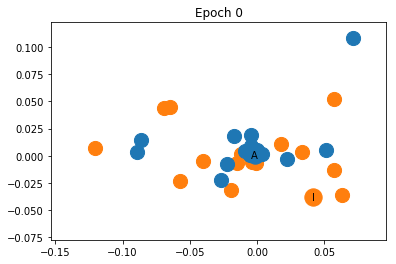

In [11]:
d = visualize_feature_representations(feature_representations_1, epoch=0)
print(d)
plt.show()

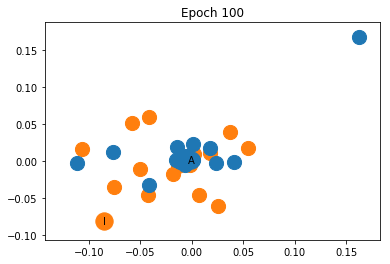

In [12]:
visualize_feature_representations(feature_representations_1, epoch=100)
plt.show()

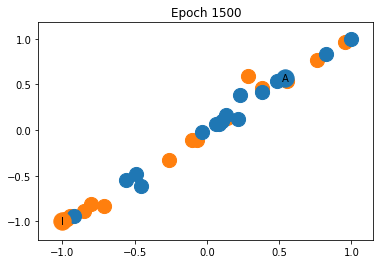

In [13]:
visualize_feature_representations(feature_representations_1, epoch=1500)
plt.show()

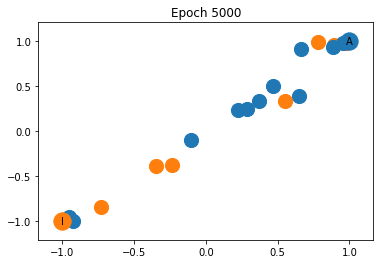

In [14]:
visualize_feature_representations(feature_representations_1)
plt.show()

### Model 2

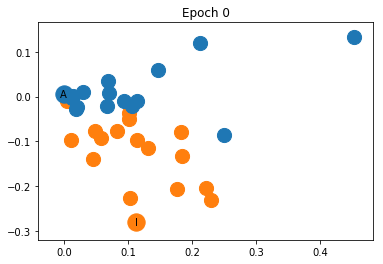

In [15]:
visualize_feature_representations(feature_representations_2, epoch=0)
plt.show()

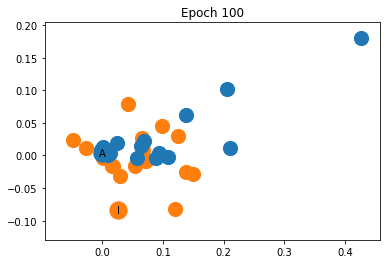

In [16]:
visualize_feature_representations(feature_representations_2, epoch=100)
plt.show()

In [17]:
visualize_feature_representations(feature_representations_2, epoch=1000)
plt.show()

IndexError: list index out of range

In [ ]:
visualize_feature_representations(feature_representations_2)
plt.show()

# Support Vector Machine

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
svc = LinearSVC()

X_gcn = features_2(X_2)
#X_gcn = X_2

X_train_svc = X_gcn[X_train].asnumpy()
X_test_svc = X_gcn[X_test].asnumpy()

svc.fit(X_train_svc, zkc.y_train)

preds_svc = svc.predict(X_test_svc)

print(classification_report(preds_svc, zkc.y_test))

In [ ]:
HTML(anim.to_html5_video())

In [ ]:
#

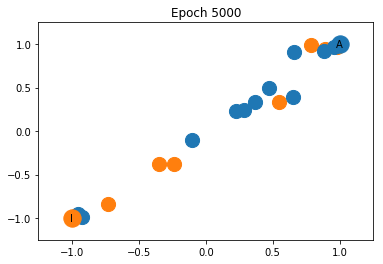

In [40]:
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML

def animate(i):
    plt.clf()
    plt.xlim(-1.25, 1.25)
    plt.ylim(-1.25, 1.25)

    artists = visualize_feature_representations(feature_representations_1, epoch=i)
    return artists

duration = 15000  # duration in ms
still_duration_start = 1000
still_duration_end = 3000

step_size = 1
interval = duration/(len(feature_representations_1)*step_size)

no_still_frames_start = int(still_duration_start/interval)
no_still_frames_end = int(still_duration_end/interval)

frames = (
    [0] * no_still_frames_start +
    list(range(0, len(feature_representations_1), step_size)) +
    [len(feature_representations_1) - 1] * no_still_frames_end)

fig = plt.gcf()
anim = animation.FuncAnimation(fig, animate, init_func=None,
                               frames=frames,
                               interval=interval, blit=True)
rc('animation', html='html5')
HTML(anim.to_html5_video())

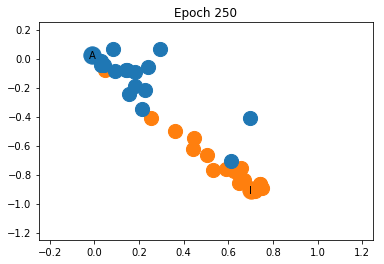

In [38]:
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML



def animate(i):
    plt.clf()
    plt.xlim(-0.25, 1.25)
    plt.ylim(-1.25, 0.25)

    artists = visualize_feature_representations(feature_representations_2, epoch=i)
    return artists

duration = 15000  # duration in ms
still_duration_start = 1000
still_duration_end = 3000

step_size = 1
interval = duration/(len(feature_representations_2)*step_size)

no_still_frames_start = int(still_duration_start/interval)
no_still_frames_end = int(still_duration_end/interval)
frames = (
    [0] * no_still_frames_start +
    list(range(0, len(feature_representations_2), step_size)) +
    [len(feature_representations_2) - 1] * no_still_frames_end
)

fig = plt.gcf()
anim = animation.FuncAnimation(fig, animate, init_func=None,
                               frames=frames,
                               interval=interval, blit=True)
rc('animation', html='html5')
HTML(anim.to_html5_video())